<h1>Evaluation Metrics for Classification</h1>

In [351]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [352]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [353]:
df = pd.read_csv('../datasets/telco_customer_churn.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [354]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [355]:
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                 int32
dtype: object

In [356]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [357]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [358]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

<h1>4.2 Accuracy and Dummy Model</h1>
<ul>
    <li>Evaluate the model on different thresholds</li>
    <li>Check the accuracy of dummy baselines</li>
</ul>

In [359]:
len(y_val)

1409

In [360]:
(y_val == churn_decision).mean()

0.8034066713981547

In [361]:
# we can move the threshold to see if it affects the accuracy
# create a range of thresholds
thresholds = np.linspace(0, 1, 21)
thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [362]:
# test each threshold and calculate the accuracy
scores = []

for t in thresholds:
    #score = (y_val == churn_decision).mean() <- can calculate your own accuracy, or use scikit-learn
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_val, y_pred >= t)
    print('Threshold: %.2f Accuracy: %.2f' % (t, score * 100) + '%')
    scores.append(score)

Threshold: 0.00 Accuracy: 27.40%
Threshold: 0.05 Accuracy: 50.89%
Threshold: 0.10 Accuracy: 59.12%
Threshold: 0.15 Accuracy: 66.64%
Threshold: 0.20 Accuracy: 70.97%
Threshold: 0.25 Accuracy: 73.88%
Threshold: 0.30 Accuracy: 76.01%
Threshold: 0.35 Accuracy: 77.22%
Threshold: 0.40 Accuracy: 78.50%
Threshold: 0.45 Accuracy: 79.35%
Threshold: 0.50 Accuracy: 80.34%
Threshold: 0.55 Accuracy: 80.13%
Threshold: 0.60 Accuracy: 79.49%
Threshold: 0.65 Accuracy: 78.64%
Threshold: 0.70 Accuracy: 76.58%
Threshold: 0.75 Accuracy: 74.45%
Threshold: 0.80 Accuracy: 73.46%
Threshold: 0.85 Accuracy: 72.60%
Threshold: 0.90 Accuracy: 72.60%
Threshold: 0.95 Accuracy: 72.60%
Threshold: 1.00 Accuracy: 72.60%


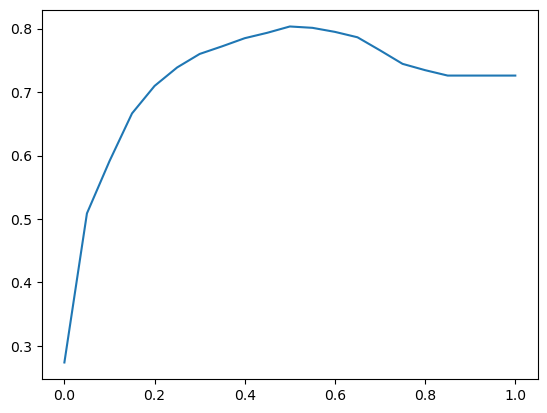

In [363]:
plt.plot(thresholds, scores)
# this plot tells us that at 1.0 the model is predicting everyone to churn and gets it
# correct around 73% of the time. This is because around 73% of customers stick around
# this means our accuracy is not much better at calculating churn than just not calculating at all.

In [364]:
# validate that there are no values above 1.0
from collections import Counter
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [365]:
y_val.mean() # 27% of users are churning

0.2739531582682754

<h1>4.3 Confusion Tables</h1>
We need a different model structure to account for the class imbalance (a majority of users do not churn)
<ul>
    <li>Different types of errors and correct decisions</li>
    <li>Arranging them in a table</li>
</ul>

In [366]:
actual_positive = (y_val == 1) # people who are going to churn
actual_negative = (y_val == 0) # people who won't churn

t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [367]:
# true positives
tp = (predict_positive & actual_positive).sum()
# true negatives
tn = (predict_negative & actual_negative).sum()
# false positives
fp = (predict_positive & actual_negative).sum()
# false negatives
fn = (predict_negative & actual_positive).sum()

In [368]:
print(tp, tn, fp, fn)

210 922 101 176


In [369]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [370]:
# calculate in terms of percentages 
(confusion_matrix / confusion_matrix.sum()).round(3)

array([[0.654, 0.072],
       [0.125, 0.149]])

<h1>4.4 Precision and Recall</h1>

In [371]:
# precision is the fraction of positive predictions that were correct
# (customers who were predicted to and did churn, out of all customers predicted to churn)
p = tp / (tp + fp)
p

# the model incorrectly predicts a churn for 33% of the customers predicted to churn

0.6752411575562701

In [372]:
# recall is the fraction of correctly identified positive examples
# (customers who were predicted to and did churn, out of all customers that did churn)
r = tp / (tp + fn)
r

# the model fails to identify 46% of the customers who actually do churn

0.5440414507772021

<h1>4.5 ROC Curves</h1>

In [373]:
# true positive rate: how many correctly identified positives out of all the actual positives
tpr = tp / (tp + fn)
# false positive rate: how many incorrectly identified positives (actual negatives) out of all the actual negatives
fpr = fp / (tn + fp)

In [374]:
# same as recall
tpr

0.5440414507772021

In [375]:
fpr

0.09872922776148582

In [376]:
# iterate over different thresholds to find the optimal one
scores = []

# set up an array of thresholds
thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t) # above threshold
    predict_negative = (y_pred < t) # below threshold

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [377]:
# create a dataframe for all threshold rates, and scores
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# calculate columns for true positive rate and false positive rate
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

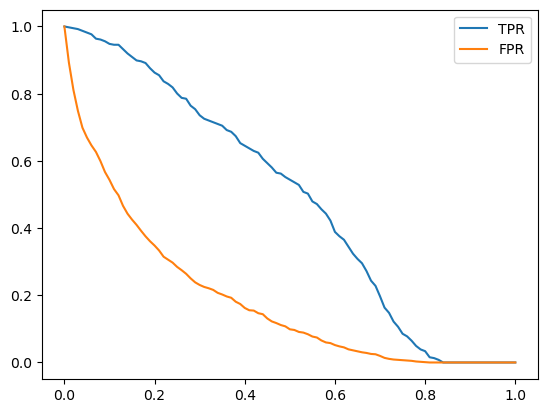

In [378]:
# plot true positive vs false positive rates
plt.plot(df_scores.threshold, df_scores['tpr'], label="TPR")
plt.plot(df_scores.threshold, df_scores['fpr'], label="FPR")
plt.legend()

In [379]:
# Create a randomized model of churn predictions
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [380]:
y_rand

array([0.44753176, 0.41664572, 0.44130723, ..., 0.18779532, 0.0123721 ,
       0.99835105])

In [381]:
# accuracy of randomized model
((y_rand >= 0.5) == y_val).mean()

0.49112845990063875

In [382]:
# create function for testing
def tpr_fpr_dataframe(y_val, y_pred):
    # iterate over different thresholds to find the optimal one
    scores = []

    # set up an array of thresholds
    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t) # above threshold
        predict_negative = (y_pred < t) # below threshold

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))
        
    # create a dataframe for all threshold rates, and scores
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    # calculate columns for true positive rate and false positive rate
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [383]:
# compare the validation dataset to the randomly generated set
df_rand = tpr_fpr_dataframe(y_val, y_rand)

df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,349,933,37,90,0.904145,0.912023
20,0.2,311,838,75,185,0.805699,0.819159
30,0.3,266,730,120,293,0.689119,0.713587
40,0.4,238,622,148,401,0.616580,0.608016
50,0.5,192,523,194,500,0.497409,0.511241
60,0.6,161,422,225,601,0.417098,0.412512
70,0.7,124,321,262,702,0.321244,0.313783
80,0.8,81,214,305,809,0.209845,0.209189
90,0.9,41,118,345,905,0.106218,0.115347


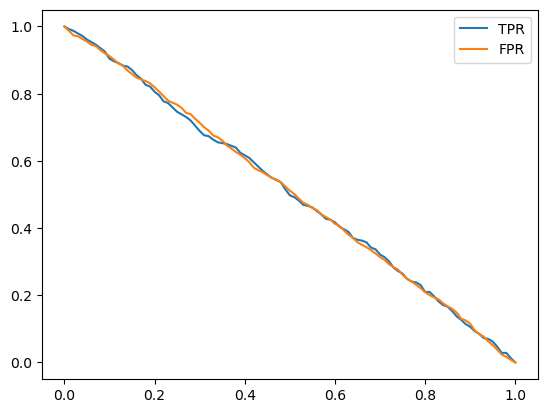

In [384]:
plt.plot(df_rand.threshold, df_rand['tpr'], label="TPR")
plt.plot(df_rand.threshold, df_rand['fpr'], label="FPR")
plt.legend()

<h3>Ideal model:</h3>
Create an ideal model to benchmark your real-world one against

In [385]:
# get counts of negatives and positives
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [386]:
# create a sorted array, with num_neg zeros and num_pos ones
# this will represent the ideal sorted set of y values
# it will act as a validation set
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [387]:
# create a sorted array of values from 0 to 1, to represent
# the ideal sorted array of predictions
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [388]:
# percentage of negative values
1 - y_val.mean()

0.7260468417317246

In [389]:
# using the exact percentage of negative values in the dataset will place
# the threshold exactly at the point in the dataset where it goes from 0 to 1.
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [390]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

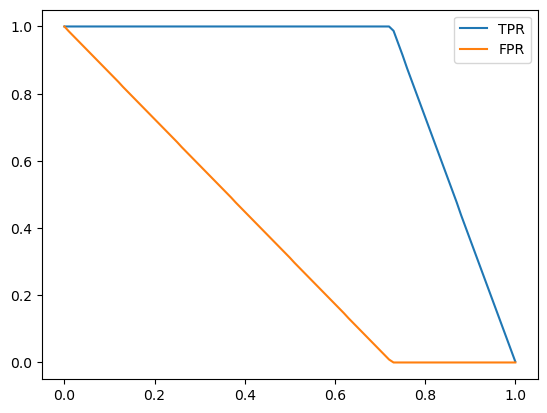

In [391]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label="TPR")
plt.plot(df_ideal.threshold, df_ideal['fpr'], label="FPR")
plt.legend()

<h3>Putting it all together:</h3>

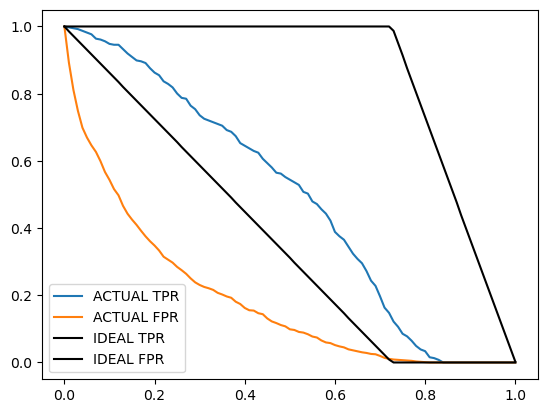

In [392]:
# plot all graphs together to determine 
plt.plot(df_scores.threshold, df_scores['tpr'], label="ACTUAL TPR")
plt.plot(df_scores.threshold, df_scores['fpr'], label="ACTUAL FPR")

#plt.plot(df_rand.threshold, df_rand['tpr'], label="RANDOM TPR", color='green')
#plt.plot(df_rand.threshold, df_rand['fpr'], label="RANDOM FPR", color='green')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label="IDEAL TPR", color='black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label="IDEAL FPR", color='black')
plt.legend()

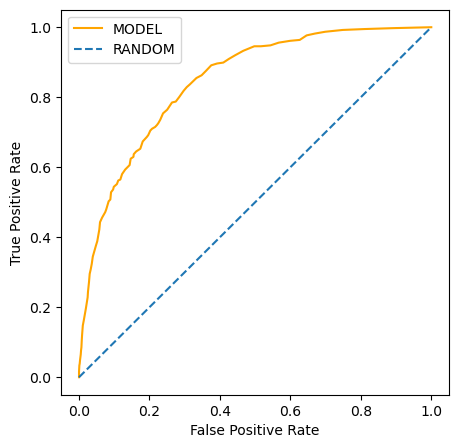

In [393]:
# plot the false positive rate against true positive rate
# for model and benchmarks

# we want it displayed as a square
plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label="MODEL", color='orange')
#plt.plot(df_rand.fpr, df_rand.tpr, label="RANDOM", color='gray')
plt.plot([0, 1], [0, 1], label="RANDOM", linestyle='--')
#plt.plot(df_ideal.fpr, df_ideal.tpr, label="IDEAL", color='green')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

<h1>4.6 ROC AUC</h1>
Area Under Curve - useful metric

In [394]:
from sklearn.metrics import roc_curve

In [395]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

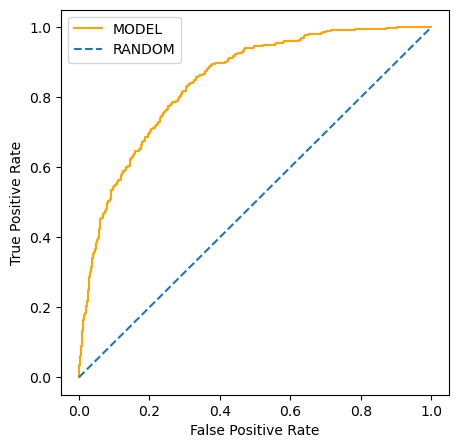

In [396]:
# difference between scikit-learn model and the one we wrote
# is that sklearn uses every data point, instead of our linspace
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label="MODEL", color='orange')
plt.plot([0, 1], [0, 1], label="RANDOM", linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [397]:
from sklearn.metrics import auc

In [398]:
auc(fpr, tpr)

0.8438530381535563

In [399]:
# sklearn model is slightly more accurate because it uses a larger threshold range than we used
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [400]:
# very close to 1.0
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [401]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(df_scores.fpr, df_scores.tpr)

0.8438732975754537

In [402]:
from sklearn.metrics import roc_auc_score

In [403]:
roc_auc_score(y_val, y_pred)

0.8438530381535563

In [404]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [405]:
import random

n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n
# result of this should be pretty close to actual AUC
# tells us how well our model can order customers

0.84455

In [406]:
# np randint is inclusive of the lower number and exclusive of the higher
n = 10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [407]:
(pos[pos_ind] > neg[neg_ind]).mean()

0.8379

<h1>4.7 Cross Validation</h1>
Evaluating the same model on different subesets of data
Getting the average prediction and the spread within predictions

In [408]:
# takes df to make feature matrix, y to feed model
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    # feature matrix
    X_train = dv.fit_transform(dicts)
    
    # C is regularization
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [409]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [410]:
# returns numpy array with predictions
predict(df_val, dv, model)

array([0.00899622, 0.20453899, 0.21223998, ..., 0.13638818, 0.79978198,
       0.837419  ])

In [411]:
# we have two functions to use, now let's implement k-fold validation
from sklearn.model_selection import KFold

In [412]:
# this takes time, use tqdm to monitor progress
from tqdm.auto import tqdm

n_splits = 5

# test regularization to optimize for final model
for C in tqdm([0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        
    print("C=%s %.3f +- %.3f" % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.009
C=0.1 0.841 +- 0.008
C=0.5 0.841 +- 0.007
C=1.0 0.841 +- 0.008
C=5.0 0.840 +- 0.007
C=10.0 0.841 +- 0.008


In [413]:
# train full train dataset final model with best C value
# 1-2% difference in AUC for testing vs. validation scores is acceptable
dv, model = train(df_full_train, df_full_train.churn.values, C=0.5)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8589665464157648